In [4]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import lightgbm
import shap
import itertools
pd.options.mode.chained_assignment = None

os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.data.gw_features import add_gw_features
from src.features.custom_transformers import TimeSeriesFeatures

%matplotlib inline
pd.set_option('display.max_columns', None)
DATA_PATH = 'data/processed/'

## Get all data

In [5]:
full_data = pd.read_parquet(DATA_PATH + 'fpl_data_all_seasons.parquet')
print(full_data.shape)
full_data.head()

(67320, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [7]:
season1617 = full_data[full_data['season'] == '2016-17']

In [8]:
season1617.shape

(23457, 73)

In [9]:
season1718 = full_data[full_data['season'] == '2017-18']
season1718.shape

(22263, 73)

In [10]:
team_total_points_1617 = season1617.groupby('team_name').sum()['total_points'].reset_index()
team_total_points_1617

,team_name,total_points
0,Arsenal,1871
1,Bournemouth,1499
2,Burnley,1380
3,Chelsea,1992
4,Crystal Palace,1475
5,Everton,1726
6,Hull City,1070
7,Leicester City,1388
8,Liverpool,1863
9,Manchester City,1807


In [11]:
final_pos_season_1617 = {
    'Arsenal': 5,
    'Bournemouth': 9,
    'Burnley': 16,
    'Chelsea': 1,
    'Crystal Palace': 14,
    'Everton': 7,
    'Hull City': 18,
    'Leicester City': 12,
    'Liverpool': 4,
    'Manchester City': 3,
    'Manchester United': 6,
    'Middlesbrough': 19,
    'Southampton': 8,
    'Stoke City': 13,
    'Sunderland': 20,
    'Swansea City': 15,
    'Tottenham Hotspur': 2,
    'Watford': 17,
    'West Bromwich Albion': 10,
    'West Ham United': 11
}

In [12]:
team_total_points_1617['final_pos'] = team_total_points_1617['team_name'].map(
    final_pos_season_1617
)

In [13]:
team_total_points_1617.sort_values('total_points', inplace=True, ascending=False)
team_total_points_1617.reset_index(drop=True, inplace=True)
team_total_points_1617.head()

,team_name,total_points,final_pos
0,Tottenham Hotspur,2061,2
1,Chelsea,1992,1
2,Arsenal,1871,5
3,Liverpool,1863,4
4,Manchester City,1807,3


In [14]:
team_squad_cost_by_gw_1617 = season1617.groupby(['team_name', 'gw']).sum()['value'].reset_index()
average_squad_cost_1617 = team_squad_cost_by_gw_1617.groupby('team_name').mean()['value'].reset_index()

average_squad_cost_1617.head()

,team_name,value
0,Arsenal,200.402778
1,Bournemouth,135.436842
2,Burnley,136.907895
3,Chelsea,181.681081
4,Crystal Palace,187.183784


In [15]:
team_points_vs_cost_1617 = team_total_points_1617.merge(
    average_squad_cost_1617,
    on='team_name'
)
team_points_vs_cost_1617.head()

,team_name,total_points,final_pos,value
0,Tottenham Hotspur,2061,2,172.424324
1,Chelsea,1992,1,181.681081
2,Arsenal,1871,5,200.402778
3,Liverpool,1863,4,173.381579
4,Manchester City,1807,3,191.086111


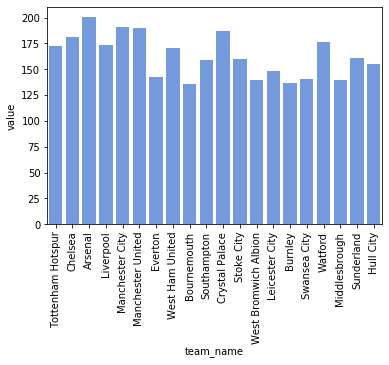

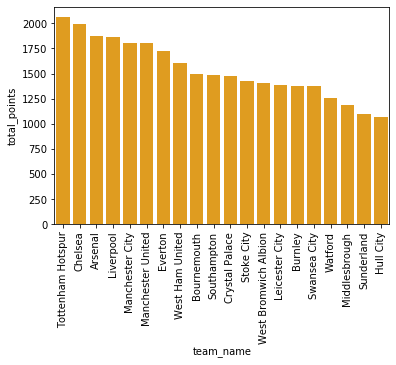

In [16]:
plt.xticks(rotation='vertical')
sns.barplot(x='team_name', y='value', data=team_points_vs_cost_1617, color='cornflowerblue')
plt.show()

plt.xticks(rotation='vertical')
sns.barplot(x='team_name', y='total_points', data=team_points_vs_cost_1617, color='orange')

## ROI by player

In [17]:
season1617_upto_gw10 = season1617[season1617['gw'] <= 10].reset_index(drop=True)
season1617_upto_gw10.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
gw1_value = season1617_upto_gw10[season1617_upto_gw10['gw'] == 1][['name', 'team_name', 'value']]
gw1_value.rename(columns={'value': 'gw1_value'}, inplace=True)

points_upto_gw10 = season1617_upto_gw10.groupby(['name', 'team_name']).sum()['total_points'].reset_index()

roi_data = gw1_value.merge(points_upto_gw10, on=['name', 'team_name'])
roi_data['ROI'] = roi_data['total_points'] / roi_data['gw1_value']
roi_data.sort_values('ROI', inplace=True, ascending=False)
roi_data.reset_index(inplace=True, drop=True)
roi_data.head(20)

,name,team_name,gw1_value,total_points,ROI
0,etienne_capoue,Watford,4.5,56,12.444444
1,tom_heaton,Burnley,4.5,50,11.111111
2,joe_allen,Stoke City,5.0,55,11.000000
3,jose_holebas,Watford,4.5,43,9.555556
4,kyle_walker,Tottenham Hotspur,5.5,51,9.272727
5,james_mcarthur,Crystal Palace,5.0,45,9.000000
6,ben_gibson,Middlesbrough,4.5,40,8.888889
7,laurent_koscielny,Arsenal,6.0,53,8.833333
8,artur_boruc,Bournemouth,4.5,39,8.666667
9,adam_smith,Bournemouth,4.5,38,8.444444


In [19]:
roi_data[roi_data['ROI'] > 0].tail(20)

,name,team_name,gw1_value,total_points,ROI
360,ashley_barnes,Burnley,4.5,1,0.222222
361,tom_carroll,Swansea City,4.5,1,0.222222
362,jordon_mutch,Crystal Palace,4.5,1,0.222222
363,joel_asoro,Sunderland,4.5,1,0.222222
364,jarrod_bowen,Hull City,4.5,1,0.222222
365,ikechi_anya,Watford,4.5,1,0.222222
366,marc_muniesa,Stoke City,4.5,1,0.222222
367,jay_fulton,Swansea City,4.5,1,0.222222
368,matej_vydra,Watford,4.5,1,0.222222
369,grant_leadbitter,Middlesbrough,5.0,1,0.200000


## Any correlation between total points in last 10 GWs of a season and first 10 GWs of the following season?

In [20]:
season1718 = full_data[full_data['season'] == '2017-18']

In [21]:
season1617.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [22]:
last_10_gw_1617 = season1617[season1617['gw']>=29].groupby('name').sum()['total_points'].reset_index()
last_10_gw_1617.head()

,name,total_points
0,aaron_cresswell,16
1,aaron_lennon,0
2,aaron_ramsdale,0
3,aaron_ramsey,38
4,aaron_wan-bissaka,0


In [23]:
first_10_gw_1718 = season1718[season1718['gw']<=10].groupby('name').sum()['total_points'].reset_index()
first_10_gw_1718.head()

,name,total_points
0,aaron_cresswell,30
1,aaron_lennon,2
2,aaron_mooy,38
3,aaron_ramsdale,0
4,aaron_ramsey,48


In [24]:
points_comparison = last_10_gw_1617.merge(
    first_10_gw_1718,
    on='name',
    suffixes=('_last_10_1617', '_first_10_1718')
)
print(points_comparison.shape)
points_comparison.head()

(411, 3)


,name,total_points_last_10_1617,total_points_first_10_1718
0,aaron_cresswell,16,30
1,aaron_lennon,0,2
2,aaron_ramsdale,0,0
3,aaron_ramsey,38,48
4,abdoulaye_doucoure,21,49


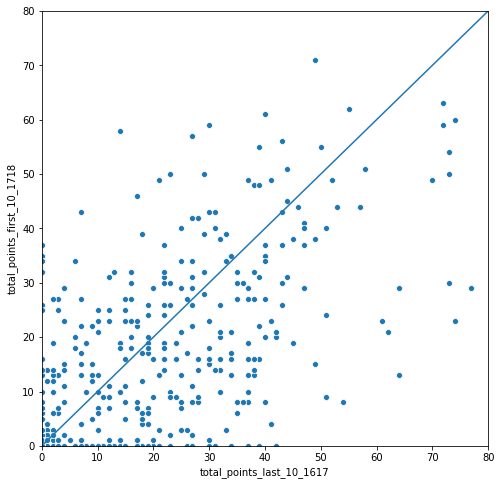

In [25]:
plt.figure(figsize=(8, 8))
plt.ylim((0, 80))
plt.xlim((0, 80))
plt.plot([0, 80], [0, 80])
sns.scatterplot(x='total_points_last_10_1617', y='total_points_first_10_1718', data=points_comparison)

In [26]:
from scipy.stats.stats import pearsonr
pearsonr(points_comparison['total_points_last_10_1617'], points_comparison['total_points_first_10_1718'])

(0.6015983672321755, 8.15726307242329e-42)

In [27]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(points_comparison['total_points_first_10_1718'], points_comparison['total_points_last_10_1617'])
res = mod.fit()

print(res.summary())

                                     OLS Regression Results                                    
Dep. Variable:     total_points_first_10_1718   R-squared (uncentered):                   0.649
Model:                                    OLS   Adj. R-squared (uncentered):              0.648
Method:                         Least Squares   F-statistic:                              757.6
Date:                        Sun, 04 Aug 2019   Prob (F-statistic):                    3.25e-95
Time:                                00:25:37   Log-Likelihood:                         -1645.6
No. Observations:                         411   AIC:                                      3293.
Df Residuals:                             410   BIC:                                      3297.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                                coef    

In [28]:
season1718 = full_data[full_data['season'] == '2017-18']

In [29]:
season1718.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
23457,aaron_cresswell,0,10,0,0,0,3,0,0,9,0.6,0,0,0,0,0,2,0,1.9,0.4,0,0,0,9,0,0,0,0,0,0,0,0,0,25136,0,0,0,0,4,18.0,0,0,0,0,5.0,False,0,0,1,2017-18,West Ham United,0,0,1,1,0,0,0,Manchester United,0,1,0,1,0,0,0,0,0,0,0,0,0,0
23458,aaron_cresswell,0,21,0,0,0,16,0,6,17,52.9,0,0,0,0,0,3,0,7.4,21.2,4,0,0,90,0,3,0,0,0,0,2,0,0,27824,0,0,0,2,3,0.0,1,-1515,945,2460,5.0,False,0,0,2,2017-18,West Ham United,0,0,1,1,0,0,0,Southampton,0,0,0,1,0,0,0,0,0,0,0,0,0,0
23459,aaron_cresswell,0,43,0,0,0,11,0,4,36,1.6,0,0,0,0,1,3,0,2.4,11.2,0,0,0,90,0,0,0,0,0,0,3,0,0,28464,0,0,1,0,3,11.0,1,-269,2323,2592,5.0,False,0,0,3,2017-18,West Ham United,0,0,1,1,0,0,0,Newcastle United,1,0,0,1,0,0,0,0,0,0,0,0,0,0
23460,aaron_cresswell,0,22,1,0,0,23,1,3,14,47.1,0,0,0,0,1,0,0,6.2,14.2,3,0,0,90,0,2,0,0,0,0,4,0,0,28977,3,0,1,0,2,1.0,6,-338,2793,3131,5.0,True,0,0,4,2017-18,West Ham United,0,0,1,1,0,0,0,Huddersfield Town,1,0,0,0,0,0,0,0,0,0,0,1,1,0
23461,aaron_cresswell,0,30,0,0,3,30,1,4,27,34.3,0,0,0,0,0,0,0,4.6,11.2,2,0,0,90,0,1,0,0,0,0,4,0,0,30355,0,0,0,0,0,0.0,9,905,3136,2231,5.0,False,0,0,5,2017-18,West Ham United,0,0,1,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:
last_10_gw_1617.head()

,name,total_points
0,aaron_cresswell,16
1,aaron_lennon,0
2,aaron_ramsdale,0
3,aaron_ramsey,38
4,aaron_wan-bissaka,0


In [69]:
gw1_value_1718 = season1718[season1718['gw'] == 1][['name', 'team_name', 'value', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID']]
gw1_value_1718.rename(columns={'value': 'gw1_value_1718'}, inplace=True)

roi_data = gw1_value_1718.merge(last_10_gw_1617, on=['name'])

In [70]:
roi_data['ROI'] = roi_data['total_points'] / roi_data['gw1_value_1718']
roi_data.sort_values('ROI', inplace=True, ascending=False)
roi_data.reset_index(inplace=True, drop=True)
roi_data.head(40)

,name,team_name,gw1_value_1718,position_DEF,position_FWD,position_GK,position_MID,total_points,ROI
0,phil_jagielka,Everton,5.0,1,0,0,0,64,12.800000
1,maya_yoshida,Southampton,5.0,1,0,0,0,53,10.600000
2,ben_davies,Tottenham Hotspur,5.5,1,0,0,0,58,10.545455
3,kyle_naughton,Swansea City,4.5,1,0,0,0,47,10.444444
4,fraser_forster,Southampton,5.0,0,0,1,0,52,10.400000
5,jack_stephens,Southampton,5.0,1,0,0,0,49,9.800000
6,lukasz_fabianski,Swansea City,4.5,0,0,1,0,43,9.555556
7,eric_bailly,Manchester United,6.0,1,0,0,0,57,9.500000
8,heung-min_son,Tottenham Hotspur,8.0,0,0,0,1,74,9.250000
9,kasper_schmeichel,Leicester City,5.0,0,0,1,0,46,9.200000


In [34]:
best_in_season1617 = season1617.groupby(['name']).sum()['total_points'].sort_values(ascending=False).head(3).reset_index()
best_in_season1617.drop('total_points', axis=1, inplace=True)
best_in_season1617['best_in_season1617'] = 1
best_in_season1617

,name,best_in_season1617
0,alexis_sanchez,1
1,bamidele_alli,1
2,harry_kane,1


In [71]:
best_in_season1617 = season1617.groupby(['name']).sum()['total_points'].sort_values(ascending=False).reset_index()
best_in_season1617.rename(columns={'total_points': 'total_points_16_17'}, inplace=True)
best_in_season1617.head()

,name,total_points_16_17
0,alexis_sanchez,264
1,bamidele_alli,225
2,harry_kane,224
3,eden_hazard,224
4,romelu_lukaku,221


# Select best team

In [72]:
from pulp import *

In [73]:
roi_data.head()

,name,team_name,gw1_value_1718,position_DEF,position_FWD,position_GK,position_MID,total_points,ROI
0,phil_jagielka,Everton,5.0,1,0,0,0,64,12.800000
1,maya_yoshida,Southampton,5.0,1,0,0,0,53,10.600000
2,ben_davies,Tottenham Hotspur,5.5,1,0,0,0,58,10.545455
3,kyle_naughton,Swansea City,4.5,1,0,0,0,47,10.444444
4,fraser_forster,Southampton,5.0,0,0,1,0,52,10.400000


In [74]:
roi_data = roi_data.merge(best_in_season1617, on=['name'], how='inner')

In [38]:
#roi_data['best_in_season1617'].fillna(0, inplace=True)

In [75]:
roi_data['name'] = roi_data['name'].str.replace(' ', '_')
roi_data['name'] = roi_data['name'].str.replace('-', '_')

In [76]:
roi_data['team_name'] = roi_data['team_name'].str.replace(' ', '_')
roi_data['team_name'] = roi_data['team_name'].str.lower()
team_names = roi_data['team_name'].unique()

In [77]:
team_names

array(['everton', 'southampton', 'tottenham_hotspur', 'swansea_city',
       'manchester_united', 'leicester_city', 'manchester_city',
       'liverpool', 'bournemouth', 'west_ham_united', 'crystal_palace',
       'arsenal', 'west_bromwich_albion', 'burnley', 'watford', 'chelsea',
       'stoke_city', 'newcastle_united', 'brighton_&_hove_albion'],
      dtype=object)

In [78]:
roi_data = pd.get_dummies(roi_data, columns=['team_name'])
roi_data.head()

,name,gw1_value_1718,position_DEF,position_FWD,position_GK,position_MID,total_points,ROI,total_points_16_17,team_name_arsenal,team_name_bournemouth,team_name_brighton_&_hove_albion,team_name_burnley,team_name_chelsea,team_name_crystal_palace,team_name_everton,team_name_leicester_city,team_name_liverpool,team_name_manchester_city,team_name_manchester_united,team_name_newcastle_united,team_name_southampton,team_name_stoke_city,team_name_swansea_city,team_name_tottenham_hotspur,team_name_watford,team_name_west_bromwich_albion,team_name_west_ham_united
0,phil_jagielka,5.0,1,0,0,0,64,12.800000,104,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,maya_yoshida,5.0,1,0,0,0,53,10.600000,78,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,ben_davies,5.5,1,0,0,0,58,10.545455,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,kyle_naughton,4.5,1,0,0,0,47,10.444444,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,fraser_forster,5.0,0,0,1,0,52,10.400000,134,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [79]:
players = list(roi_data['name'])

In [80]:
team_dict = {}

for team in team_names:
    team_dict[team] = dict(
        zip(
            roi_data['name'],
            roi_data[f'team_name_{team}']
        )
    
    )

In [81]:
costs = dict(
    zip(
        roi_data['name'],
        roi_data['gw1_value_1718']
    )
)

In [82]:
DEF_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_DEF']
    )
)

FWD_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_FWD']
    )
)

GK_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_GK']
    )
)

MID_flag = dict(
    zip(
        roi_data['name'],
        roi_data['position_MID']
    )
)

In [83]:
roi = dict(
    zip(
        roi_data['name'],
        roi_data['ROI']
    )
)

In [85]:
best_in_prev_season = dict(
    zip(
        roi_data['name'],
        #roi_data['best_in_season1617']
        roi_data['total_points_16_17']
    )
)

In [86]:
prob = LpProblem('FPL team selection', LpMaximize)

In [87]:
player_vars = LpVariable.dicts('player', players, 0, 1, LpInteger)

In [88]:
# Objective function:
#prob += lpSum([roi[p] * player_vars[p] for p in players]), "Total ROI of team"
prob += lpSum([best_in_prev_season[p] * player_vars[p] for p in players]), "Total points last season of team"

In [89]:
# Constraints
prob += lpSum([costs[p] * player_vars[p] for p in players]) <= 100, "Total cost less than £100m"

prob += lpSum(player_vars[p] for p in players) == 15, "Select 15 players"

prob += lpSum(DEF_flag[p] * player_vars[p] for p in players) == 5, "5 defenders"

prob += lpSum(GK_flag[p] * player_vars[p] for p in players) == 2, "2 goalkeepers"

prob += lpSum(MID_flag[p] * player_vars[p] for p in players) == 5, "5 midfielders"

prob += lpSum(FWD_flag[p] * player_vars[p] for p in players) == 3, "3 forwards"

for team in team_dict.keys():
    prob += lpSum(team_dict[team][p] * player_vars[p] for p in players) <= 3, f"Max 3 players in the same {team}"
    
#prob += lpSum(best_in_prev_season[p] * player_vars[p] for p in players) == 3, "3 of best in previous season"

In [90]:
prob.solve()

1

In [91]:
chosen_players = []
for v in prob.variables():
    if v.varValue == 0:
        continue
    else:
        print(v.name, "=", v.varValue)
        chosen_players.append(v.name.replace('player_', ''))

player_bamidele_alli = 1.0
player_cesar_azpilicueta = 1.0
player_charlie_daniels = 1.0
player_christian_eriksen = 1.0
player_etienne_capoue = 1.0
player_fraser_forster = 1.0
player_gareth_mcauley = 1.0
player_gary_cahill = 1.0
player_jermain_defoe = 1.0
player_joe_allen = 1.0
player_joshua_king = 1.0
player_marcos_alonso = 1.0
player_robert_snodgrass = 1.0
player_roberto_firmino = 1.0
player_tom_heaton = 1.0


In [92]:
test = roi_data[
    roi_data['name'].isin(
        chosen_players
    )
]
test

,name,gw1_value_1718,position_DEF,position_FWD,position_GK,position_MID,total_points,ROI,total_points_16_17,team_name_arsenal,team_name_bournemouth,team_name_brighton_&_hove_albion,team_name_burnley,team_name_chelsea,team_name_crystal_palace,team_name_everton,team_name_leicester_city,team_name_liverpool,team_name_manchester_city,team_name_manchester_united,team_name_newcastle_united,team_name_southampton,team_name_stoke_city,team_name_swansea_city,team_name_tottenham_hotspur,team_name_watford,team_name_west_bromwich_albion,team_name_west_ham_united
4,fraser_forster,5.0,0,0,1,0,52,10.400000,134,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
17,joshua_king,7.5,0,1,0,0,62,8.266667,178,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,tom_heaton,5.0,0,0,1,0,40,8.000000,149,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,gary_cahill,6.5,1,0,0,0,51,7.846154,178,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,charlie_daniels,5.0,1,0,0,0,39,7.800000,134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,christian_eriksen,9.5,0,0,0,1,74,7.789474,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
36,cesar_azpilicueta,6.5,1,0,0,0,50,7.692308,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43,bamidele_alli,9.5,0,0,0,1,70,7.368421,225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
46,marcos_alonso,7.0,1,0,0,0,51,7.285714,177,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95,etienne_capoue,5.5,0,0,0,1,31,5.636364,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [93]:
test.sum()

name                                fraser_forsterjoshua_kingtom_heatongary_cahill...
gw1_value_1718                                                                    100
position_DEF                                                                        5
position_FWD                                                                        3
position_GK                                                                         2
position_MID                                                                        5
total_points                                                                      646
ROI                                                                           96.8707
total_points_16_17                                                               2422
team_name_arsenal                                                                   0
team_name_bournemouth                                                               3
team_name_brighton_&_hove_albion                      

# How does best team score in first 10 GWs?

In [94]:
season1718_first10 = season1718[season1718['gw'] <= 10]

In [95]:
season1718_first10_best = season1718_first10[season1718_first10['name'].isin(chosen_players)]

In [96]:
season1718_first10_best.groupby('gw').sum()['total_points']

gw
1     44
2     47
3     65
4     31
5     52
6     54
7     34
8     28
9     33
10    35
Name: total_points, dtype: int64

In [97]:
season1718_first10_best['total_points'].sum()

423

### Things to try:

- Build a forecast points model which takes GW 39-48 (i.e. first 10 GWs of following season)
- See what happens if objective function is MAX(expected points for next 10 GWs)
- See if the same players are selected in both objective functions
- Try MAX(expected points ROI + last 10 GWs of previous season ROI) i.e. combined objective
- Try building a model only using known future features e.g. opposition (top 6, promoted), match time, past record against team (?)